In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL


from google.colab import drive



In [26]:
import pathlib


drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/DL_HW/weather_dataset/'

data_dir = pathlib.Path(data_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

539


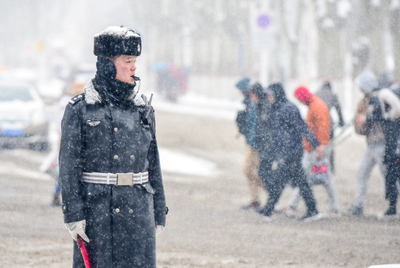

In [28]:
snow=list(data_dir.glob('snow/*.jpg'))
PIL.Image.open(str(snow[0]))

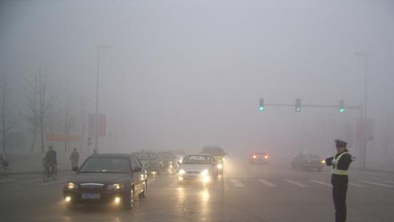

In [29]:
fogsmog=list(data_dir.glob('fogsmog/*.jpg'))
PIL.Image.open(str(fogsmog[0]))

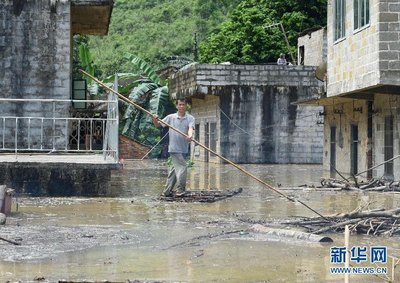

In [30]:
rain=list(data_dir.glob('rain/*.jpg'))
PIL.Image.open(str(rain[0]))

# STEP 2

In [31]:
#PYTORCH

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


batch_size = 32
img_height = 180
img_width = 180

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# Load the training dataset using ImageFolder
train_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transform
)

# Load the validation dataset using ImageFolder
val_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transform
)


# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Get class names
class_names = train_dataset.classes
print(class_names)




['fogsmog', 'rain', 'snow']


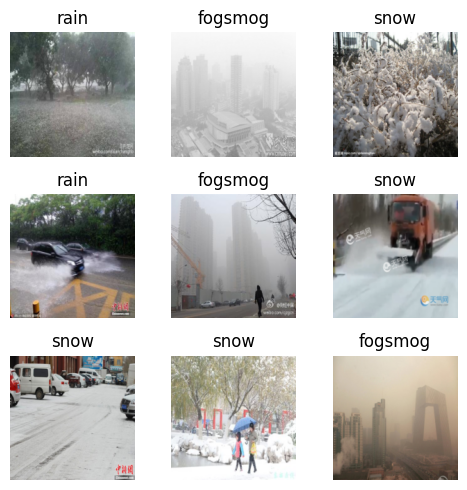

In [32]:
#pytorch

import torchvision
import matplotlib.pyplot as plt

# Fetch a batch of images and labels from the train_loader
images, labels = next(iter(train_loader))

# Define class names
class_names = train_dataset.classes

# Shuffle indices
indices = np.random.permutation(len(labels))

# Plot the images
plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    idx = indices[i]
    plt.imshow(images[idx].permute(1, 2, 0))
    plt.title(class_names[labels[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [33]:
for images_batch, labels_batch in train_loader:
    # Print the shape of the image batch and label batch
    print(images_batch.shape)
    print(labels_batch.shape)
    break

torch.Size([32, 3, 180, 180])
torch.Size([32])


# Step 3: PreProcessing

 **Normalization**

In [34]:
#pytorch

import torch
from torchvision import transforms

# Define normalization transformation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Apply normalization to the train_dataset and val_dataset
train_dataset_normalized = datasets.ImageFolder(
    root=data_dir,
    transform=transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        normalize,
    ])
)

val_dataset_normalized = datasets.ImageFolder(
    root=data_dir,
    transform=transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        normalize,
    ])
)

# Define batch size
batch_size = 32

# Create data loaders
train_loader_normalized = DataLoader(train_dataset_normalized, batch_size=batch_size, shuffle=True)
val_loader_normalized = DataLoader(val_dataset_normalized, batch_size=batch_size, shuffle=False)

# Fetch a batch of images and labels from the train_loader_normalized
images_batch_normalized, labels_batch_normalized = next(iter(train_loader_normalized))
# Print the minimum and maximum pixel values of the first image
print(images_batch_normalized[0].min().item(), images_batch_normalized[0].max().item())


-1.9809060096740723 2.640000104904175


 **Data Augumentation**

In [35]:
#pytorch

# Define data augmentation transformations
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(img_height, img_width), scale=(0.9, 1.1)),
])

# Apply data augmentation transformations to the train_dataset
train_dataset_augmented = datasets.ImageFolder(
    root=data_dir,
    transform=transforms.Compose([
        data_augmentation,
        transforms.ToTensor(),
    ])
)

# Define batch size
batch_size = 32

# Create data loader for augmented dataset
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Fetch a batch of images and labels from the train_loader_augmented
images_batch_augmented, labels_batch_augmented = next(iter(train_loader_augmented))


# Step 4: CNN model

In [37]:
#pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

num_classes = 3
num_epochs=10

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (img_height // 8) * (img_width // 8), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize the model
cnn_model = CNNModel(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters())


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = cnn_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation loop
    cnn_model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        for val_data, val_target in val_loader:
            val_output = cnn_model(val_data)
            val_loss += criterion(val_output, val_target).item()
            _, val_predicted = torch.max(val_output, 1)
            val_total += val_target.size(0)
            val_correct += (val_predicted == val_target).sum().item()
        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / val_total

    # Print training statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Once training is done, you can plot the training and validation metrics if needed


Epoch [1/10], Train Loss: 0.9350, Train Accuracy: 57.88%, Val Loss: 0.5904, Val Accuracy: 79.59%, Overall Val Accuracy: 79.59%
Epoch [2/10], Train Loss: 0.5975, Train Accuracy: 77.37%, Val Loss: 0.4568, Val Accuracy: 82.37%, Overall Val Accuracy: 82.37%
Epoch [3/10], Train Loss: 0.5719, Train Accuracy: 77.55%, Val Loss: 0.4372, Val Accuracy: 83.12%, Overall Val Accuracy: 83.12%
Epoch [4/10], Train Loss: 0.4164, Train Accuracy: 82.75%, Val Loss: 0.3945, Val Accuracy: 85.71%, Overall Val Accuracy: 85.71%
Epoch [5/10], Train Loss: 0.4334, Train Accuracy: 82.19%, Val Loss: 0.3531, Val Accuracy: 87.38%, Overall Val Accuracy: 87.38%
Epoch [6/10], Train Loss: 0.4185, Train Accuracy: 83.67%, Val Loss: 0.3187, Val Accuracy: 89.05%, Overall Val Accuracy: 89.05%
Epoch [7/10], Train Loss: 0.3503, Train Accuracy: 87.38%, Val Loss: 0.2913, Val Accuracy: 89.61%, Overall Val Accuracy: 89.61%
Epoch [8/10], Train Loss: 0.2795, Train Accuracy: 89.98%, Val Loss: 0.2335, Val Accuracy: 91.09%, Overall Val A

Number of image files found: 4
['fogsmog', 'rain', 'snow']
Loading image from: /content/drive/MyDrive/DL_HW/weather_test_unseen/test1.jpeg


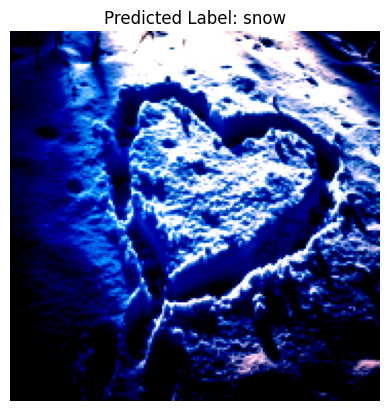

Loading image from: /content/drive/MyDrive/DL_HW/weather_test_unseen/test3.jpeg


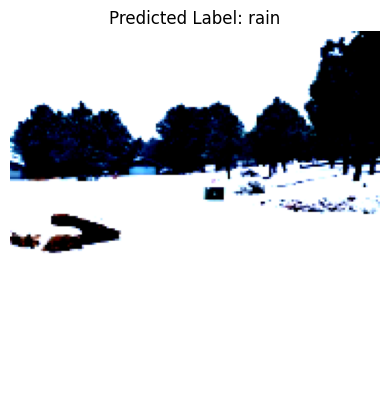

Loading image from: /content/drive/MyDrive/DL_HW/weather_test_unseen/test2.jpeg


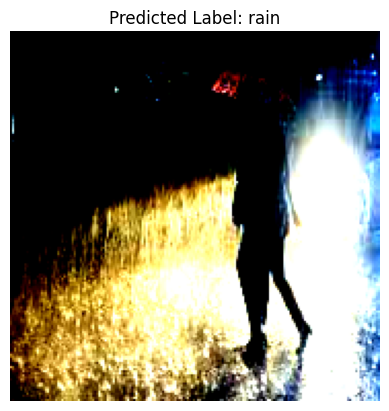

Loading image from: /content/drive/MyDrive/DL_HW/weather_test_unseen/test4.jpeg


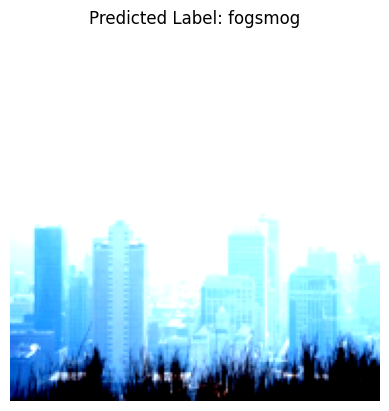

In [42]:
#pytorch


import torch
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
from PIL import Image
import matplotlib.pyplot as plt

test_dir = '/content/drive/MyDrive/DL_HW/weather_test_unseen/'


import os

# Define custom dataset class for the test data
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform

        # List all image files in the directory
        self.image_files = [file for file in os.listdir(directory) if file.endswith('.jpeg')]

        # Debug print to check the number of images found
        print("Number of image files found:", len(self.image_files))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image_path = os.path.join(self.directory, self.image_files[idx])
        print("Loading image from:", image_path)

        image = Image.open(image_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image

# Define test dataset using custom dataset class
test_dataset = CustomTestDataset(directory=test_dir, transform=transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    normalize,
]))

class_names = train_dataset.classes
print(class_names)


for images in test_loader:
    # Perform prediction
    output = cnn_model(images)
    probabilities = torch.softmax(output, dim=1)
    predicted_probs, predicted_labels = torch.max(probabilities, 1)

    # Convert tensor to NumPy array and transpose the dimensions
    img = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))

    # Display the image and predicted label
    plt.imshow(img)
    plt.title(f"Predicted Label: {class_names[predicted_labels.item()]}")
    plt.axis("off")
    plt.show()




# Step 6: GoogleNet

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Define the number of classes
num_classes = 3

# Load the pre-trained InceptionV3 model
inception_net = models.inception_v3(pretrained=True, aux_logits=True)

# Freeze the parameters of the pre-trained model
for param in inception_net.parameters():
    param.requires_grad = False

# Modify the fully connected layer for the new task
inception_net.fc = nn.Sequential(
    nn.Linear(inception_net.fc.in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, num_classes)
)

# Define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transfer the model to the device
inception_net = inception_net.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_net.parameters())

# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define custom dataset class for the test data
class CustomTestDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [file for file in os.listdir(directory) if file.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Define test dataset using custom dataset class
test_dir = '/content/drive/MyDrive/DL_HW/weather_test_unseen/'
test_dataset = CustomTestDataset(directory=test_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Iterate over the images in the test directory
for image in test_loader:
    # Perform prediction
    image = image.to(device)
    output = inception_net(image)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

    # Convert tensor image to numpy array
    img = np.transpose(image.squeeze(0).cpu().numpy(), (1, 2, 0))

    # Display the image and predicted label
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis("off")
    plt.show()


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/10
14/14 [==============================] - 15s 458ms/step - loss: 81.8933 - accuracy: 0.5324 - val_loss: 24.7617 - val_accuracy: 0.6729
Epoch 2/10
14/14 [==============================] - 1s 62ms/step - loss: 17.0147 - accuracy: 0.6574 - val_loss: 12.6553 - val_accuracy: 0.7103
Epoch 3/10
14/14 [==============================] - 1s 55ms/step - loss: 9.6029 - accuracy: 0.7292 - val_loss: 12.4064 - val_accuracy: 0.6822
Epoch 4/10
14/14 [==============================] - 1s 55ms/step - loss: 5.7294 - accuracy: 0.7454 - val_loss: 5.4698 - val_accuracy: 0.7944
Epoch 5/10
14/14 [==============================] - 1s 55ms/step - loss: 2.4312 - accuracy: 0.7940 - val_loss: 3.3277 - val_accuracy: 0.7664
Epoch 6/10
14/14 [==============================] - 1s 56ms/step - loss: 2.3203 - accuracy: 0.7708 - val_loss: 3.6581 - val_accuracy: 0.7477
Epoch 7/10
14/14 [==============================] - 1s 57ms/step - loss: 1.9161 - 

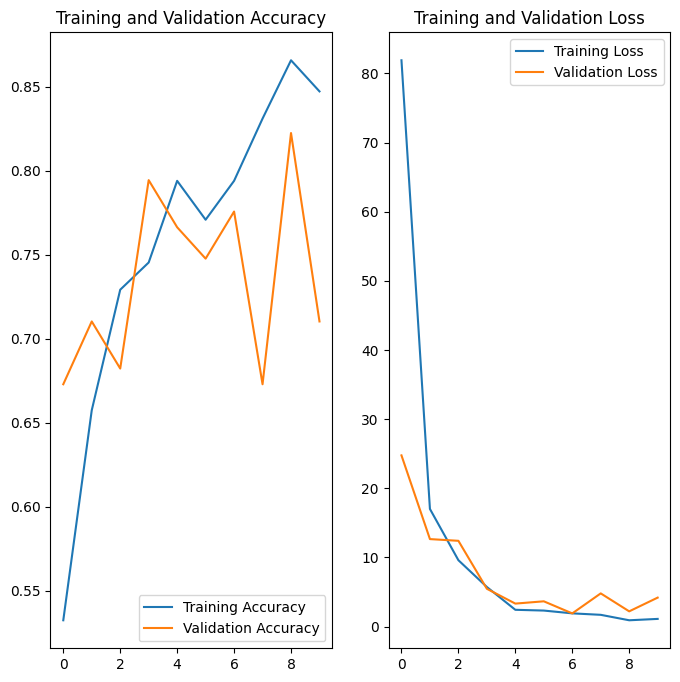

1/1 [==============================] - 2s 2s/step
[[1.0994624e-30 3.9105718e-03 9.9608946e-01]]
2


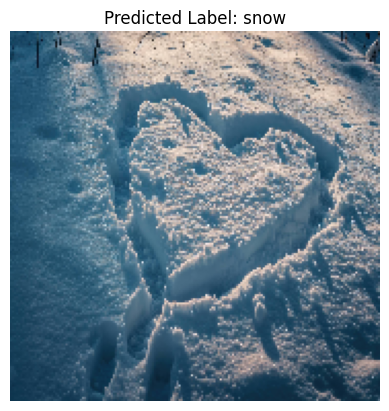

1/1 [==============================] - 0s 34ms/step
[[0.0000000e+00 1.0000000e+00 5.1015043e-08]]
1


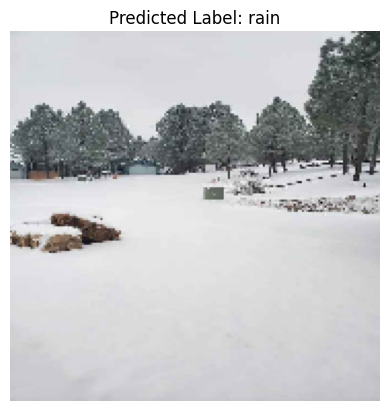

1/1 [==============================] - 0s 26ms/step
[[2.4638540e-36 3.6124742e-01 6.3875252e-01]]
2


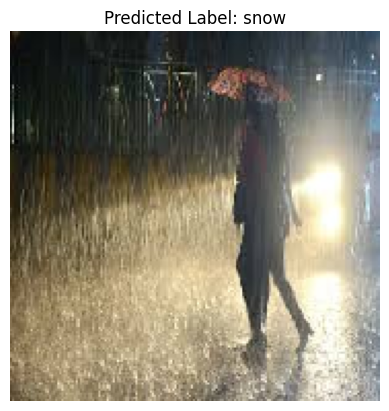

1/1 [==============================] - 0s 25ms/step
[[1.0000000e+00 3.1336635e-18 2.8573836e-25]]
0


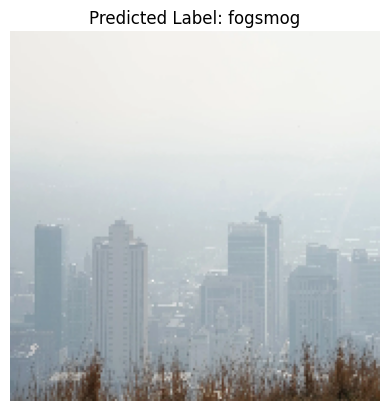

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator



num_classes =3
inception_net = InceptionV3(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

x = inception_net.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

inception_model = Model(inputs=inception_net.input, outputs=predictions)

for layer in inception_net.layers:
   layer.trainable = False


inception_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


epochs=10
inceptionnet_history = inception_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


inc_acc = inceptionnet_history.history['accuracy']
inc_val_acc = inceptionnet_history.history['val_accuracy']

inc_loss = inceptionnet_history.history['loss']
inc_val_loss = inceptionnet_history.history['val_loss']

overall_val_accuracy = inception_model.evaluate(val_ds)[1]
print("Overall Validation Accuracy:", overall_val_accuracy)


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, inc_acc, label='Training Accuracy')
plt.plot(epochs_range, inc_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, inc_loss, label='Training Loss')
plt.plot(epochs_range, inc_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#TEST ON UNSEEN DATA


test_dir = '/content/drive/MyDrive/DL_HW/weather_test_unseen/'

test_dir = pathlib.Path(test_dir)

# Iterate over the images in the test directory
for image_path in test_dir.glob("*"):
    # Load and preprocess the image
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)

    # Perform prediction
    prediction = inception_model.predict(img_array)
    print(prediction)
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]
    print(predicted_label)

    # Decode the predicted label (assuming you have a list of class names)
    predicted_class = class_names[predicted_label]

    # Display the image and predicted label
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_class}")
    plt.axis("off")
    plt.show()

with data augumentation and Dropout

Epoch 1/15
14/14 [==============================] - 10s 218ms/step - loss: 43.2788 - accuracy: 0.5417 - val_loss: 16.7340 - val_accuracy: 0.6822
Epoch 2/15
14/14 [==============================] - 2s 112ms/step - loss: 29.4850 - accuracy: 0.6481 - val_loss: 11.5115 - val_accuracy: 0.7944
Epoch 3/15
14/14 [==============================] - 2s 109ms/step - loss: 23.1642 - accuracy: 0.6551 - val_loss: 7.3293 - val_accuracy: 0.7664
Epoch 4/15
14/14 [==============================] - 4s 196ms/step - loss: 12.3720 - accuracy: 0.6898 - val_loss: 12.6304 - val_accuracy: 0.6355
Epoch 5/15
14/14 [==============================] - 2s 113ms/step - loss: 13.8681 - accuracy: 0.6528 - val_loss: 8.1514 - val_accuracy: 0.6729
Epoch 6/15
14/14 [==============================] - 3s 123ms/step - loss: 10.1545 - accuracy: 0.6574 - val_loss: 3.8405 - val_accuracy: 0.8037
Epoch 7/15
14/14 [==============================] - 2s 109ms/step - loss: 5.5623 - accuracy: 0.6852 - val_loss: 2.8271 - val_accuracy: 0.8

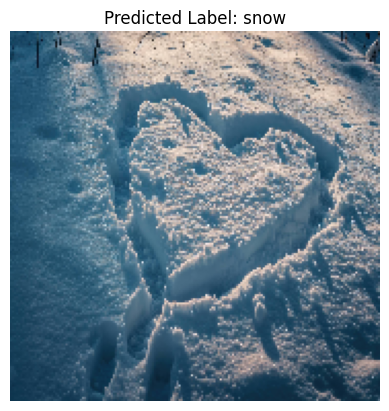

1/1 [==============================] - 0s 38ms/step
[[0.01119196 0.49360055 0.49520743]]
2


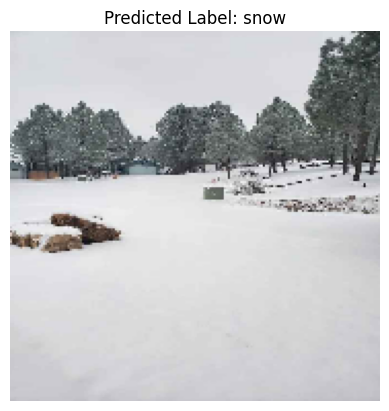

1/1 [==============================] - 0s 26ms/step
[[5.7157222e-06 4.9750760e-01 5.0248665e-01]]
2


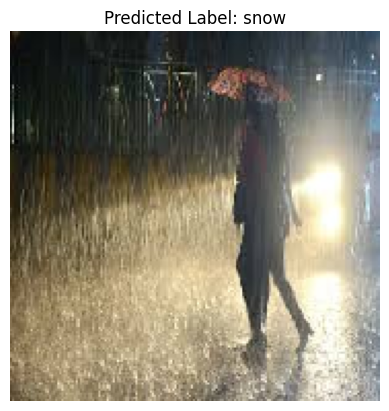

1/1 [==============================] - 0s 30ms/step
[[9.9999988e-01 9.4617086e-08 4.9080101e-10]]
0


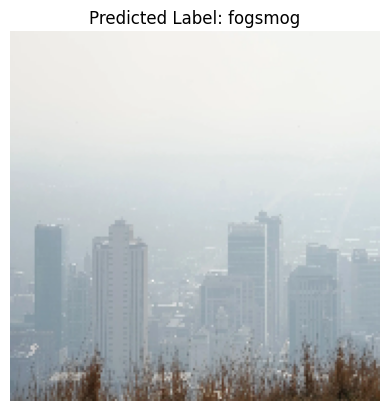

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator


num_classes = 3

# Load InceptionNet without the top layers
inception_net = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Apply data augmentation to input
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)

# Include InceptionV3 model
x = inception_net(x, training=False)

# Add custom linear layer on top
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
x = layers.Dense(1024, activation='relu')(x)  # Custom dense layer
x = layers.Dropout(0.5)(x)  # Dropout layer
predictions = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

# Combine base model and custom layers
inception_model_1 = Model(inputs=inputs, outputs=predictions)


for layer in inception_net.layers:
   layer.trainable = False

# Compile the model
inception_model_1.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

epochs = 15
inceptionnet_history_1= inception_model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)




overall_val_accuracy = inception_model_1.evaluate(val_ds)[1]
print("Overall Validation Accuracy:", overall_val_accuracy)


#TEST ON UNSEEN DATA


test_dir = '/content/drive/MyDrive/DL_HW/weather_test_unseen/'

test_dir = pathlib.Path(test_dir)

# Iterate over the images in the test directory
for image_path in test_dir.glob("*"):
    # Load and preprocess the image
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)

    # Perform prediction
    prediction = inception_model_1.predict(img_array)
    print(prediction)
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]
    print(predicted_label)

    # Decode the predicted label (assuming you have a list of class names)
    predicted_class = class_names[predicted_label]

    # Display the image and predicted label
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_class}")
    plt.axis("off")
    plt.show()



# Results and Discussion

1) The CNN model provides an overall accuracy of 0.88%

2) Transfer Learning : The Google inceptionNet model updated with an linear layer on top provided an accuracy of 0.71%

3) Inception Net model is tuned by increasing the epoches , data agumentation along with dropout of 0.2 improved the performance to 0.74%

4) The Base CNN Model provides better accuracy for this usecase than Inceptionnet.